In [1]:
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import mdtraj
from AIGLE import Trajectory
from AIGLE.utilities import *
from openmm.app import *
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['lines.markersize'] = 0
mpl.rcParams['lines.marker'] = 'o'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 12


np.set_printoptions(precision=4)
dev = 'cuda' if th.cuda.is_available() else 'cpu'
temp = 300 
kb = 8.314462618e-3 
kbT = kb * temp


## define topology of CG system

In [2]:
nmain = 20
main_topol = mdtraj.Topology()
chain = main_topol.add_chain()
for ii in range(nmain):
    residue = main_topol.add_residue('R{}'.format(ii), chain)
    main_topol.add_atom('C{}'.format(ii), Element.getBySymbol('C'), residue) 
main_atoms = [x for x in main_topol.atoms]
for ii in range(nmain-1):
    main_topol.add_bond(main_atoms[ii], main_atoms[ii+1])

## load gle data

In [11]:
DT = 0.1  ## dump frequency
nmax = int(100/DT)  ## calculate MSD for 100ps
## gle
traj  = mdtraj.load("gle_traj_N{}.dcd".format(nmain), top=main_topol)
traj = traj.xyz
gle_sep = traj[:,-1] - traj[:,0]  ## head-tail displacement
gle_traj = Trajectory(gle_sep, DT, kbT=kbT)
gle_traj.process_kinetics(transform=False)
gle_msd = gle_traj.compute_msd(nmax)


## load LE data

In [12]:
DT = 0.1  ## dump frequency
nmax = int(100/DT)
## gle
traj  = mdtraj.load("le_traj_N{}.dcd".format(nmain), top=main_topol)
traj = traj.xyz
le_sep = traj[:,-1] - traj[:,0]   ## head-tail displacement
le_traj = Trajectory(le_sep, DT, kbT=kbT)
le_traj.process_kinetics(transform=False)
le_msd = le_traj.compute_msd(nmax)


## load MD data

In [13]:
# md
DT = 0.1
md_dt = 0.002
md_traj = np.load('traj_2fs.npy')[::int(DT/md_dt)]
md_sep = md_traj[:, -1] - md_traj[:, 0]   ## head-tail displacement
md_traj = Trajectory(md_sep, DT, kbT=kbT)
md_traj.process_kinetics(transform=False)
md_msd = md_traj.compute_msd(nmax)


## compare MSD

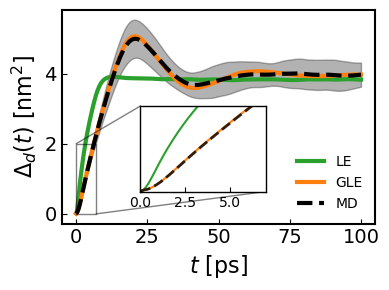

In [14]:
nmax = int(100/DT)
# plot
axis_name = ['x', 'y', 'z']
fig, ax = plt.subplots(1,1, figsize=(4,3))
 
mpl.rcParams['lines.markersize'] = 0

ax.plot(np.arange(nmax)*DT, le_msd.sum(-1), label='LE', color='tab:green', linewidth=3, )
# ax.fill_between(np.arange(nmax)*DT,  le_msd.sum(-1) - le_msd.std(-1)*3, le_msd.sum(-1) + le_msd.std(-1)*3, color='tab:orange', alpha=0.4)
ax.plot(np.arange(nmax)*DT, gle_msd.sum(-1), label='GLE', color='tab:orange', linewidth=3,  )
ax.plot(np.arange(nmax)*DT, md_msd.sum(-1), label='MD', color='black',   linewidth=3, linestyle='dashed')
ax.fill_between(np.arange(nmax)*DT,  md_msd.sum(-1) - md_msd.std(-1)*3, md_msd.sum(-1) + md_msd.std(-1)*3, color='black', alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=14)

mpl.rcParams['lines.markersize'] = 0
axins = ax.inset_axes(
    [0.25, 0.15, 0.4, 0.4], xlim=(-0.01, 7), ylim=(-0.01, 2))
axins.plot(np.arange(nmax)*DT, le_msd.sum(-1), label='LE', color='tab:green', linewidth=1.5)
# ax.fill_between(np.arange(nmax)*DT,  le_msd.sum(-1) - le_msd.std(-1)*3, le_msd.sum(-1) + le_msd.std(-1)*3, color='tab:orange', alpha=0.4)
axins.plot(np.arange(nmax)*DT, gle_msd.sum(-1), label='GLE', color='tab:orange', linewidth=1.5)
axins.plot(np.arange(nmax)*DT, md_msd.sum(-1), label='MD', color='black', alpha=0.8, linewidth=2, linestyle='dashed')
axins.tick_params(axis='both', which='major', labelsize=10)
# axins.get_xaxis().set_visible(False)
axins.get_yaxis().set_visible(False)
# change all spines
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(1.0)
    
    
ax.set_xlabel(r'$t$ [ps]', fontsize=16 )
ax.set_ylabel(r'$\Delta_d(t)$ [$\mathrm{nm^2}$]', fontsize=16 )
ax.legend(frameon=False, fontsize=10)
# ax.set_title('head-tail distance diffusion')
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.tight_layout()
plt.savefig('MSD.png', dpi=200)

## calculate MFPT

In [23]:
### compute mfpt
ms_states = np.linspace(0.2, 3.2, 31)
print('states are ', ms_states)
nms = ms_states.shape[0]
sigma = 0.02
if os.path.exists('fpt_data') is False:
    os.mkdir('fpt_data')
gle_d = (gle_sep**2).sum(-1)**0.5
le_d = (le_sep**2).sum(-1)**0.5
md_d = (md_sep**2).sum(-1)**0.5

states are  [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2]


In [25]:
for i in [3,18]:
    print('analyzing ({},*) entry '.format(i))
    for j in range(nms):
        if i == j:
            continue
        start = ms_states[i]
        end = ms_states[j]

        traj_fpt = fpt(gle_d , start, end, sigma) 
        traj_fpt = traj_fpt  * DT  
        np.save('fpt_data/gle_{:.1f}to{:.1f}_sigma002'.format(start,end), traj_fpt)

        traj_fpt = fpt(le_d , start, end, sigma) 
        traj_fpt = traj_fpt  * DT  
        np.save('fpt_data/le_{:.1f}to{:.1f}_sigma002'.format(start,end), traj_fpt)
        
        traj_fpt = fpt(md_d , start, end, sigma) 
        traj_fpt = traj_fpt  * DT 
        np.save('fpt_data/md_{:.1f}to{:.1f}_sigma002'.format(start,end), traj_fpt)

analyzing (3,*) entry 
analyzing (18,*) entry 


## compare MFPT

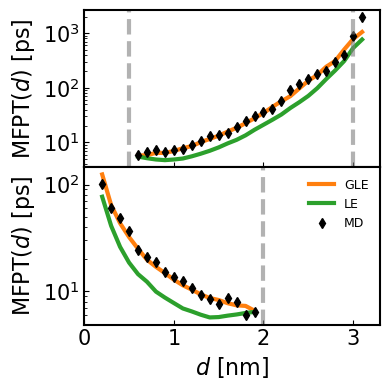

In [26]:
fig, ax = plt.subplots(2, 1,  figsize=(4,4), sharex=True, sharey=False)


### forward MFPT
gle_mfpt_forward = []
le_mfpt_forward = []
md_mfpt_forward = []

i=3
forward_x = []
for j in range(i,  nms-1):
    if i==j:
        continue
    start = ms_states[i]
    end = ms_states[j]
    gle_fpt = np.load('fpt_data/gle_{:.1f}to{:.1f}_sigma002.npy'.format(start,end))
    le_fpt = np.load('fpt_data/le_{:.1f}to{:.1f}_sigma002.npy'.format(start,end))
    md_fpt = np.load('fpt_data/md_{:.1f}to{:.1f}_sigma002.npy'.format(start,end))
    gle_mfpt_forward.append(gle_fpt.mean())
    le_mfpt_forward.append(le_fpt.mean())    
    md_mfpt_forward.append(md_fpt.mean())        
    forward_x.append(end)


# ax[0].xaxis.set_ticks([0.5-0.02, 0.5+0.02])
# ax[1].axvline(start, linestyle='dashed', color='grey', alpha=0.6, linewidth = 3)
ax[0].semilogy(forward_x, gle_mfpt_forward, label='GLE', linewidth=3, color='tab:orange')
ax[0].semilogy(forward_x, le_mfpt_forward, label='LE', linewidth=3, color='tab:green')
ax[0].semilogy(forward_x, md_mfpt_forward, label='MD', marker='d', markersize=5, linewidth=0, color='black')    
ax[0].set_xlim(0.0, 3.3)
    
### backword MFPT
gle_mfpt_backward = []
le_mfpt_backward = []
md_mfpt_backward = []

backward_x = []
i=18
for j in range(i):
    if i==j:
        continue
    start = ms_states[i]
    end = ms_states[j]
    gle_fpt = np.load('fpt_data/gle_{:.1f}to{:.1f}_sigma002.npy'.format(start,end))
    le_fpt = np.load('fpt_data/le_{:.1f}to{:.1f}_sigma002.npy'.format(start,end))
    md_fpt = np.load('fpt_data/md_{:.1f}to{:.1f}_sigma002.npy'.format(start,end))
    gle_mfpt_backward.append(gle_fpt.mean())
    le_mfpt_backward.append(le_fpt.mean())    
    md_mfpt_backward.append(md_fpt.mean())        
    backward_x.append(end)


ax[1].semilogy(backward_x, gle_mfpt_backward, label='GLE', linewidth=3, color='tab:orange')
ax[1].semilogy(backward_x, le_mfpt_backward, label='LE', linewidth=3, color='tab:green')
ax[1].semilogy(backward_x, md_mfpt_backward, label='MD', marker='d', markersize=5, linewidth=0, color='black')
# ax[1].legend(frameon=False, fontsize=10, loc='upper center')
ax[1].set_xlim(0.0, 3.3)



ax[1].legend(frameon=False, fontsize=9, loc='upper right')
ax[0].axvline(0.5, linestyle='dashed', color='grey', alpha=0.6, linewidth = 3)
# ax[1].axvline(0.5, linestyle='dashed', color='grey', alpha=0.6, linewidth = 3)
ax[0].axvline(3.0, linestyle='dashed', color='grey', alpha=0.6, linewidth = 3)
# ax[0].axvline(start, linestyle='dashed', color='grey', alpha=0.6, linewidth = 3)
ax[1].axvline(2.0, linestyle='dashed', color='grey', alpha=0.6, linewidth = 3)
# ax[0].set_xlabel(r'$d$ [nm]', fontsize=16 )
ax[1].set_xlabel(r'$d$ [nm]', fontsize=16 )
ax[0].set_ylabel(r'MFPT($d$) [ps]', fontsize=16 )
ax[1].set_ylabel(r'MFPT($d$) [ps]', fontsize=16 )

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('polymer_MFPT.png', dpi=250)
